In this notebook we evaluate each of the following classification models:

1. Logistic regression (for classification)
2. Support vector classification
3. Decision tree classification
4. Random forest classification
5. k-nearest neighbours classification
6. AdaBoost classification
7. Gaussian naive Bayes classification
8. Neural network classification

**Run the code below** to import required packages.


In [5]:
import numpy as np
import os
import sklearn as sk
from sklearn import linear_model, tree, svm, ensemble, neighbors, naive_bayes, neural_network
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, ParameterGrid
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from scipy.io.arff import loadarff
import pandas as pd
import scipy
import matplotlib.pyplot as plt

### Data and Classifier Parameters  

In [8]:
#Relative path root for datasets
file_loc = os.path.join(os.getcwd(),'Datasets/')

#Dataset files and parameters based on descriptions
dataset_details = {
    'credit':
        {
            'file': ['default of credit card clients.xls'],
            'load_params': {
                'index_col': 0,
                'skiprows': 1
            }
        },
    'breast_cancer':
        {
            'file': ['breast-cancer-wisconsin.data'],
            'load_params': {
                'na_values': '?',
                'index_col': 0
            }
        },
    'statlog':
        {
            'file': ['german.data-numeric'],
            'load_params': {
                'delim_whitespace': 'true'
            }
        },
    'adult':
        {
            'file': ['adult.data','adult.test'],
            'load_params': {
                'na_values': '?',
                'comment': '|'
            }
        },
    'yeast': {
        'file': ['yeast.data'],
        'load_params': {
            'index_col': 0,
            'delim_whitespace': 'true'
        }
    },
    'thoracic': {
        'file': ['ThoraricSurgery.arff'],
        'load_params': {}
    },
    'seismic': {
        'file': ['seismic-bumps.arff'],
        'load_params': {}
    },
    'retinopathy': {
        'file': ['messidor_features.arff'],
        'load_params': {
            'comment': '@'
        }
    }
}

# Classifiers used and their subset of hyperparameters chosen to test with gridsearch
CLASSIFIERS = {
    'logreg': {
        'clf': linear_model.LogisticRegression,
       'param_grid': {
            'C' : [100, 10, 1.0, 0.1, 0.01],
            'random_state': [0]
        },
        'params': {
            'credit': {'C': 0.1, 'random_state': 0},
            'breast_cancer': {'C': 1.0, 'random_state': 0},
            'statlog': {'C': 1.0, 'random_state': 0},
            'adult': {'C': 0.1, 'random_state': 0},
            'yeast': {'C': 0.1, 'random_state': 0},
            'thoracic': {'C': 0.01, 'random_state': 0},
            'seismic': {'C': 100, 'random_state': 0},
            'retinopathy': {'C': 0.1, 'random_state': 0}
        }
    },
    'tree': {
        'clf': tree.DecisionTreeClassifier,
        'param_grid': {
            'min_samples_split': [2, 5, 10],
            'max_depth': [5,10,20,50,100,None],
            'random_state': [0]
        },
        'params': {
            'credit':{'max_depth': 5, 'min_samples_split': 2, 'random_state': 0},
            'breast_cancer':{'max_depth': 5, 'min_samples_split': 2, 'random_state': 0},
            'statlog':{'max_depth': 5, 'min_samples_split': 10, 'random_state': 0},
            'adult':{'max_depth': 5, 'min_samples_split': 2, 'random_state': 0},
            'yeast': {'max_depth': 5, 'min_samples_split': 10, 'random_state': 0},
            'thoracic':{'max_depth': 5, 'min_samples_split': 2, 'random_state': 0},
            'seismic':{'max_depth': 5, 'min_samples_split': 10, 'random_state': 0},
            'retinopathy':{'max_depth': 10, 'min_samples_split': 5, 'random_state': 0} 
        }
    },
    'kneighbors': {
        'clf': neighbors.KNeighborsClassifier,
        'param_grid': {
            'leaf_size': [1,5,10,20,50],
            'n_neighbors': [1,5,10,20,30],
            'p': [1,2]
        },
        'params': {
        'credit':{'leaf_size': 1, 'n_neighbors': 30, 'p': 2},
        'breast_cancer':{'leaf_size': 1, 'n_neighbors': 10, 'p': 2},
        'statlog':{'leaf_size': 1, 'n_neighbors': 20, 'p': 2},
        'adult':{'leaf_size': 1, 'n_neighbors': 10, 'p': 1},
        'yeast': {'leaf_size': 1, 'n_neighbors': 10, 'p': 1},
        'thoracic':{'leaf_size': 1, 'n_neighbors': 10, 'p': 1},
        'seismic':{'leaf_size': 1, 'n_neighbors': 30, 'p': 1},
        'retinopathy':{'leaf_size': 1, 'n_neighbors': 20, 'p': 1}
        }
    },
    'adaboost': {
        'clf': ensemble.AdaBoostClassifier,
        'param_grid': {
            'n_estimators': [10, 50, 100, 500],
            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
            'random_state': [0]
            },
        'params': {
            'credit':{'learning_rate': 0.0001, 'n_estimators': 10},
            'breast_cancer':{'learning_rate': 0.1, 'n_estimators': 50},
            'statlog':{'learning_rate': 0.1, 'n_estimators': 500},
            'adult':{'learning_rate': 0.1, 'n_estimators': 10},
            'yeast':{'learning_rate': 1.0, 'n_estimators': 10},
            'thoracic':{'learning_rate': 0.01, 'n_estimators': 500},
            'seismic':{'learning_rate': 0.0001, 'n_estimators': 10},
            'retinopathy':{'learning_rate': 0.1, 'n_estimators': 500}
        }
    },
    'forest': {
        'clf': ensemble.RandomForestClassifier,
        'param_grid': {
            'max_depth': [5, 10, 20, 50, 100, None],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [100, 500, 1000, 1500, 2000]
        },
        'params': {
            'credit':{'max_depth': 10, 'min_samples_split': 2},
            'breast_cancer':{'max_depth': 10, 'min_samples_split': 10},
            'statlog':{'max_depth': 50, 'min_samples_split': 2},
            'adult':{'max_depth': 20, 'min_samples_split': 5},
            'yeast': {'max_depth': 10, 'min_samples_split': 5},
            'thoracic':{'max_depth': 5, 'min_samples_split': 2},
            'seismic':{'max_depth': 10, 'min_samples_split': 5},
            'retinopathy':{'max_depth': 20, 'min_samples_split': 2}
            }
    },  
    'nb': {
        'clf': naive_bayes.GaussianNB,
        'param_grid': {},
        'params': {
            'credit': {},
            'breast_cancer': {},
            'statlog': {},
            'adult': {},
            'yeast': {},
            'thoracic': {},
            'seismic': {},
            'retinopathy': {} 

        }
    },
    'svc': {
        'clf': svm.SVC, 
        'param_grid': {
            'kernel': ['rbf'],
            'C': [50, 10, 1.0, 0.1, 0.01]
        },
        'params': {
        'credit':{'C': 1.0, 'kernel': 'rbf'},
        'breast_cancer':{'C': 1.0, 'kernel': 'rbf'},
        'statlog':{'C': 1.0, 'kernel': 'rbf'},
        'adult':{'C': 1.0, 'kernel': 'rbf'},
        'yeast':{'C': 1.0, 'kernel': 'rbf'},
        'thoracic':{'C': 1.0, 'kernel': 'rbf'},
        'seismic':{'C': 1.0, 'kernel': 'rbf'},
        'retinopathy':{'C': 1.0, 'kernel': 'rbf'}
        }
    },
    'neural': {
        'clf': neural_network.MLPClassifier,
        'param_grid': {
            'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
            'max_iter': [100]
        },
        'params': {
            'credit':{'activation': 'relu', 'hidden_layer_sizes': (100,), 'max_iter': 500},
            'breast_cancer':{'activation': 'relu', 'hidden_layer_sizes': (100,), 'max_iter': 500},
            'statlog':{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'max_iter': 500},
            'adult':{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'max_iter': 500},
            'yeast': {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'max_iter': 500},
            'thoracic':{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'max_iter': 500},
            'seismic':{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'max_iter': 500},
            'retinopathy': {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'max_iter': 500}
        }
    }
}


### Preprocessing the data

In [3]:
def preprocessor(dataset_details, file_loc, strategy='mean', encoder=StandardScaler, gridsearchflag=False):

    '''
    Loads all datasets in
    Standardizes to dataframe
    Splits into train and testing data
    '''

    train_data = {}
    test_data = {}

    for dataset in dataset_details:
        if (gridsearchflag==True):
            if (dataset!='yeast'):
                continue
        X, y = load_dataset(dataset_details[dataset], file_loc)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

        #Encode categorical values and scale numeric values
        X_enc, y_enc = create_encoders(X_train, y_train, encoder)
        X_train = X_enc.transform(X_train)
        X_test = X_enc.transform(X_test)
        
        if scipy.sparse.issparse(X_train):
            X_train = X_train.toarray()
            X_test = X_test.toarray()
        if y_enc:
            y_train = y_enc.transform(y_train)
            y_test = y_enc.transform(y_test)

        X_imp, X_train, X_test = impute(X_train, X_test, strategy)

        train_data[dataset] = {
            'X_train': X_train,
            'y_train': y_train,
        }
        test_data[dataset] = {
            'X_test': X_test,
            'y_test': y_test,
            'X_imp': X_imp,
            'X_enc': X_enc,
            'y_enc': y_enc
        }

    return train_data, test_data

def impute(X_train, X_test, strategy='mean'):
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    X_imp = imp.fit(X_train)
    X_train = X_imp.transform(X_train)
    X_test = X_imp.transform(X_test)

    return X_imp, X_train, X_test

def create_encoders(X, y, encoder):

    '''
    Splits dataset into numerical and categorical data
    creates relevant encoders for both features and labels
    '''

    cat_enc = OneHotEncoder(handle_unknown='ignore')
    num_enc = encoder()

    cat_features = X.select_dtypes(include=['object']).columns
    num_features =X.select_dtypes(include=['int64', 'float64']).columns

    if len(cat_features)==0:
        X_enc = num_enc
    elif len(num_features)==0:
        X_enc = cat_enc
    else:
        X_enc = ColumnTransformer(
            transformers=[
                ("num", num_enc, num_features),
                ("cat", cat_enc, cat_features)
            ]
        )

    X_enc.fit(X)
    
    y_enc = None
    if y.dtypes=='object':
        y_enc = LabelEncoder().fit(y)


    return X_enc, y_enc
    
def load_dataset(dataset, file_loc):
    '''
    Loads in a dataset according to type and load_params
    Assumes dataset file is either .xls, .arff, or plain text
    If test and train are pre-split, assumes they are the same file type and combines for preprocessing.
    Separates out the last column as y
    '''

    #metadata = dataset_details[dataset]
    filenames = dataset['file']
    load_params = dataset['load_params']

    dfs = []
    for file in filenames:
        extension = file.split('.')[1]  # Get file type
        file = f'{file_loc}{file}'
        if extension == 'xls':
            df = load_excel(file, **load_params)
        elif extension == 'arff':
            df = load_arff(file)
        else:
            df = load_plaintext(file, **load_params)
        dfs.append(df)
        df = pd.concat(dfs)
    
    y = df.iloc[:,-1]
    X = df = df.iloc[: , :-1]

    return X, y

def load_excel(file,  **kwargs):
    df = pd.read_excel(file, dtype=None, engine='xlrd', **kwargs)
    return df

def load_arff(file):
    data = loadarff(file)
    df = pd.DataFrame(data[0])
    return df

def load_plaintext(file, **kwargs):
    df = pd.read_csv(file, header=None, dtype=None, **kwargs)
    return df

train_data, test_data = preprocessor(dataset_details, file_loc)

### Train Data

In [9]:
def train_classifiers(data, CLASSIFIERS):

    '''
    Trains every classifier on every dataset
    '''

    models = {}
    for clf in CLASSIFIERS:
        models[clf]={}
        for dataset in data:
            print("Training ",clf," on ",dataset)
            model = train_clf(CLASSIFIERS[clf], data[dataset]['X_train'], data[dataset]['y_train'], **CLASSIFIERS[clf]['params'][dataset])
            models[clf][dataset] = {
                'model': model
            }
        

    return models

def train_clf(clf_data, X, y, **params):

    '''
    Trains a given classifier on a given dataset
    '''
    clf = clf_data['clf']
    model = clf(**params).fit(X,y)
    
    return model


models = train_classifiers(train_data, CLASSIFIERS)


Training  logreg  on  credit
Training  logreg  on  breast_cancer
Training  logreg  on  statlog
Training  logreg  on  adult


D:\Anaconda\envs\comp432\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\envs\comp432\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Training  logreg  on  yeast
Training  logreg  on  thoracic
Training  logreg  on  seismic
Training  logreg  on  retinopathy
Training  tree  on  credit
Training  tree  on  breast_cancer
Training  tree  on  statlog
Training  tree  on  adult
Training  tree  on  yeast
Training  tree  on  thoracic
Training  tree  on  seismic
Training  tree  on  retinopathy
Training  kneighbors  on  credit
Training  kneighbors  on  breast_cancer
Training  kneighbors  on  statlog
Training  kneighbors  on  adult
Training  kneighbors  on  yeast
Training  kneighbors  on  thoracic
Training  kneighbors  on  seismic
Training  kneighbors  on  retinopathy
Training  adaboost  on  credit
Training  adaboost  on  breast_cancer
Training  adaboost  on  statlog
Training  adaboost  on  adult
Training  adaboost  on  yeast
Training  adaboost  on  thoracic
Training  adaboost  on  seismic
Training  adaboost  on  retinopathy
Training  forest  on  credit
Training  forest  on  breast_cancer
Training  forest  on  statlog
Training  fo

D:\Anaconda\envs\comp432\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training  neural  on  adult
Training  neural  on  yeast


D:\Anaconda\envs\comp432\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training  neural  on  thoracic


D:\Anaconda\envs\comp432\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training  neural  on  seismic


D:\Anaconda\envs\comp432\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training  neural  on  retinopathy


### Choose Hyperparameters

In [20]:
def find_hyperparams(classifier_details, X, y, gridsearch):
    params = classifier_details['params']
    model = classifier_details['clf'](**params)
    param_grid = classifier_details['param_grid']
    cv = KFold(n_splits=5)
    search = gridsearch(model, param_grid, cv=cv, n_jobs=-1)

    result = search.fit(X, y)
    print (result.best_params_)

def find_all_hyperparams(data, classifiers, datasets, gridsearch=GridSearchCV, gridsearchflag=False):
    count = 0
    for clf in classifiers:
        if (count !=4):
            count +=1
            continue
        for dataset in datasets:
            if (gridsearchflag==True):
                if (dataset!='yeast'): continue
            find_hyperparams(classifiers[clf], data[dataset]['X_train'], data[dataset]['y_train'], gridsearch)
        count+=1

find_all_hyperparams(train_data,CLASSIFIERS, dataset_details)

### Test Models

In [3]:
def test_classifiers(data, models, scoring=f1_score, gridsearchflag=False):
    scores = {}

    for clf in models:
        scores[clf] = []
        for dataset in models[clf]:
            if (gridsearchflag==True):
                if (dataset!='yeast'): continue
            score = test_clf(models[clf][dataset], data[dataset])
            scores[clf].append(score)

    scores = pd.DataFrame.from_dict(scores,orient='index',columns=dataset_details.keys())
    np.set_printoptions(edgeitems=3)
    np.core.arrayprint._line_width = 100
    print(scores)
            

def test_clf(models, test_data):
    model = models['model']
    X = test_data['X_test']
    y = test_data['y_test']

    X = test_data['X_imp'].transform(X)
    
    if scipy.sparse.issparse(X):
        X = X.toarray()
    if models.get('y_enc'):
        y = models['y_enc'].transform(y)
    
    y_pred = model.predict(X)
    f1 = f1_score(y,y_pred,average='micro')
    
    return round(f1,2)

test_classifiers(test_data, models)

NameError: name 'test_data' is not defined

### Decision Gridsearch (Novelty Component)

The aim of a "decision gridsearch" is to analyze the decisions made at every step of preprocessing, training and testing, to determine if what we as students thought made sense actually corresponds to the highest scores. While we can't try every decision or every possibility for a given decision, the goal is to give some insight as to what kind of decisions need to have more thought put into them and what kind have minimal impact on a given type of dataset.

In [20]:
example_dataset = 'yeast' #Chose a dataset that had particularly low scores to begin with 

decisions = {
    'strategy': ['mean','most_frequent'],
    'scaler': [MinMaxScaler, StandardScaler],
    'gridsearch': [GridSearchCV, RandomizedSearchCV],
    'scoring': [f1_score, 'score']
}

combinations = ParameterGrid(decisions)

for combination in combinations:
    strategy = combination['strategy']
    scaler = combination['scaler']
    gridsearch = combination['gridsearch']
    scoring = combination['scoring']
    print(strategy, scaler, gridsearch, scoring)
    preprocessor(dataset_details, file_loc, strategy=strategy, encoder=scaler, gridsearchflag=True)
    find_all_hyperparams(train_data, models, CLASSIFIERS, gridsearch=gridsearch, gridsearchflag=True)
    test_classifiers(test_data, models, gridsearchflag=True)
    




mean <class 'sklearn.preprocessing._data.MinMaxScaler'> <class 'sklearn.model_selection._search.GridSearchCV'> <function f1_score at 0x000002717C167B80>
            yeast
logreg       0.59
tree         0.59
kneighbors   0.58
adaboost     0.44
most_frequent <class 'sklearn.preprocessing._data.MinMaxScaler'> <class 'sklearn.model_selection._search.GridSearchCV'> <function f1_score at 0x000002717C167B80>
            yeast
logreg       0.59
tree         0.59
kneighbors   0.58
adaboost     0.44
mean <class 'sklearn.preprocessing._data.MinMaxScaler'> <class 'sklearn.model_selection._search.GridSearchCV'> score
            yeast
logreg       0.59
tree         0.59
kneighbors   0.58
adaboost     0.44
most_frequent <class 'sklearn.preprocessing._data.MinMaxScaler'> <class 'sklearn.model_selection._search.GridSearchCV'> score
            yeast
logreg       0.59
tree         0.59
kneighbors   0.58
adaboost     0.44
mean <class 'sklearn.preprocessing._data.StandardScaler'> <class 'sklearn.model_se

### Plots

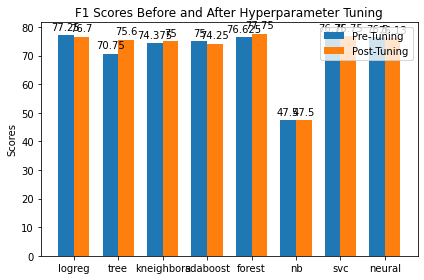

In [7]:
classifiers = ['logreg', 'tree', 'kneighbors', 'adaboost', 'forest', 'nb', 'svc', 'neural']
datasets = ['credit','breast_cancer','statlog','adult','yeast','thoracic','seismic','retinopathy']
tree = [0.82,0.96,0.72,0.57,0.59,0.82,0.94,0.63]
kneighbors = [0.81,0.97,0.72,0.53,0.58,0.82,0.95,0.62]
adaboost = [0.83,0.96,0.74,0.54,0.44,0.82,0.95,0.66]
forest=[0.82,0.97,0.76,0.58,0.63,0.82,0.95,0.69]
nb=[0.64,0.95,0.69,0.19,0.11,0.19,0.42,0.61]
svc=[0.82,0.96,0.75,0.57,0.61,0.82,0.95,0.66]
neural=[0.81,0.97,0.75,0.52,0.60,0.80,0.94,0.70]

x = np.arange(len(classifiers))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/8, tree, width, label='Pre-Tuning')
rects2 = ax.bar(x + width/8, post_hp_ave, width, label='Post-Tuning')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('F1 Scores Before and After Hyperparameter Tuning')
ax.set_xticks(x, classifiers)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()